Problem Statement (Loan Dataset – Imbalanced Data)
In a loan approval system, most applicants may be approved, while only a few are rejected,
leading to an imbalanced dataset. Machine learning models trained on such data become
biased toward the majority class.

The objective is to identify the imbalance and apply SMOTE to balance the dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv("Loan.csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [6]:
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTarget Variable Distribution:")
print(df['Loan_Status'].value_counts())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None

Missing Values:
Loan_ID               0
Gender               13
Married               3
Dep

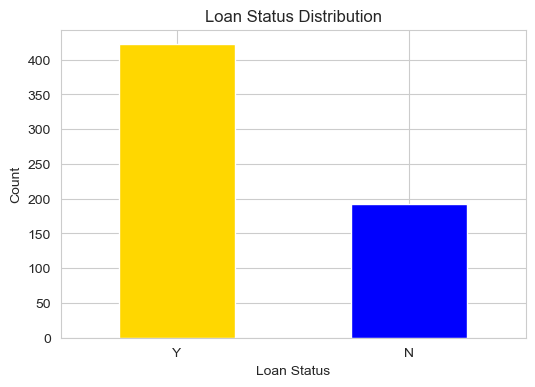

In [7]:
plt.figure(figsize=(6, 4))
df['Loan_Status'].value_counts().plot(kind='bar', color=['gold', 'blue'])
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [8]:
approved = df['Loan_Status'].value_counts()['Y']
rejected = df['Loan_Status'].value_counts()['N']
imbalance_ratio = approved / rejected
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1 (Approved:Rejected)")


Imbalance Ratio: 2.20:1 (Approved:Rejected)


In [9]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

In [10]:
df = df.drop('Loan_ID', axis=1)


In [13]:
label_encoders = {}
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education',
                    'Self_Employed', 'Property_Area', 'Loan_Status']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("\nAfter preprocessing:")
print(df.head())



After preprocessing:
   Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0       1        0           0          0              0             5849   
1       1        1           1          0              0             4583   
2       1        1           0          0              1             3000   
3       1        1           0          1              0             2583   
4       1        0           0          0              0             6000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0       128.0             360.0             1.0   
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   

   Property_Area  Loan_Status  
0              2            1  
1              0            0 

In [14]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

print("\nFeatures shape:", X.shape)
print("Target shape:", y.shape)
print("\nClass distribution before SMOTE:")
print(y.value_counts())


Features shape: (614, 11)
Target shape: (614,)

Class distribution before SMOTE:
Loan_Status
1    422
0    192
Name: count, dtype: int64


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("\nTraining set class distribution:")
print(y_train.value_counts())


Training set size: (491, 11)
Test set size: (123, 11)

Training set class distribution:
Loan_Status
1    337
0    154
Name: count, dtype: int64


In [18]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE - Training set class distribution:")
print(pd.Series(y_train_balanced).value_counts())


After SMOTE - Training set class distribution:
Loan_Status
1    337
0    337
Name: count, dtype: int64


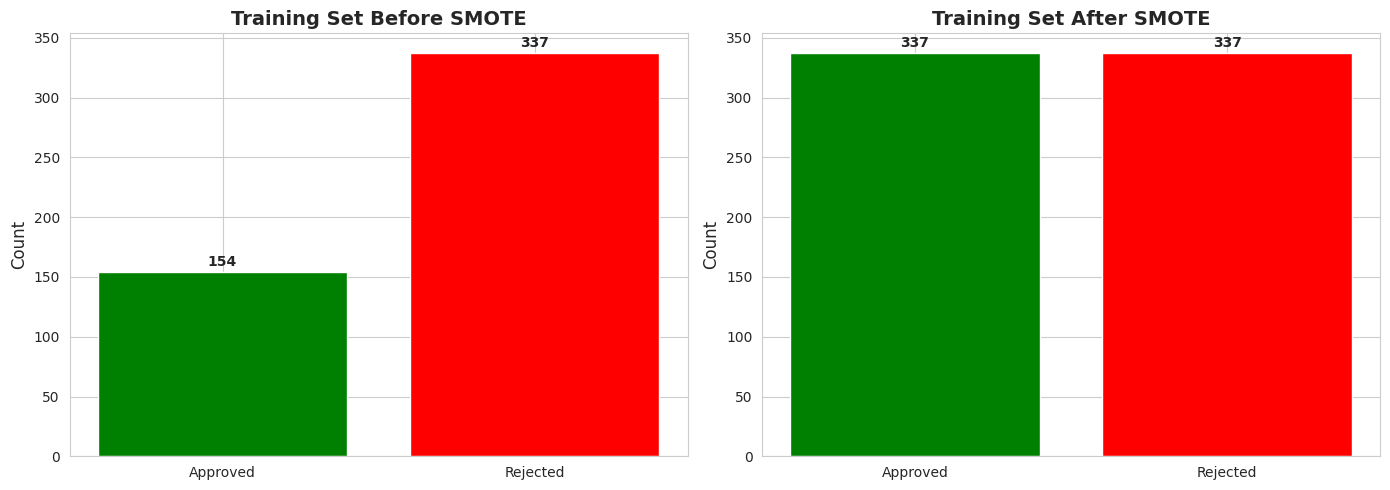

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Before SMOTE
axes[0].bar(['Approved', 'Rejected'], y_train.value_counts().sort_index(),
            color=['green', 'red'])
axes[0].set_title('Training Set Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
for i, v in enumerate(y_train.value_counts().sort_index()):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# After SMOTE
axes[1].bar(['Approved', 'Rejected'],
            pd.Series(y_train_balanced).value_counts().sort_index(),
            color=['green', 'red'])
axes[1].set_title('Training Set After SMOTE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12)
for i, v in enumerate(pd.Series(y_train_balanced).value_counts().sort_index()):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [22]:
print("\n" + "="*60)
print("MODEL 1: Random Forest WITHOUT SMOTE")
print("="*60)
rf_imbalanced = RandomForestClassifier(random_state=42, n_estimators=100)
rf_imbalanced.fit(X_train, y_train)
y_pred_imbalanced = rf_imbalanced.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_imbalanced))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_imbalanced,
                          target_names=['Rejected', 'Approved']))
print(f"Accuracy: {accuracy_score(y_test, y_pred_imbalanced):.4f}")


MODEL 1: Random Forest WITHOUT SMOTE

Confusion Matrix:
[[24 14]
 [ 7 78]]

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.77      0.63      0.70        38
    Approved       0.85      0.92      0.88        85

    accuracy                           0.83       123
   macro avg       0.81      0.77      0.79       123
weighted avg       0.83      0.83      0.82       123

Accuracy: 0.8293


In [23]:
print("\n" + "="*60)
print("MODEL 2: Random Forest WITH SMOTE")
print("="*60)
rf_balanced = RandomForestClassifier(random_state=42, n_estimators=100)
rf_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = rf_balanced.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_balanced))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_balanced,
                          target_names=['Rejected', 'Approved']))
print(f"Accuracy: {accuracy_score(y_test, y_pred_balanced):.4f}")


MODEL 2: Random Forest WITH SMOTE

Confusion Matrix:
[[25 13]
 [11 74]]

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.69      0.66      0.68        38
    Approved       0.85      0.87      0.86        85

    accuracy                           0.80       123
   macro avg       0.77      0.76      0.77       123
weighted avg       0.80      0.80      0.80       123

Accuracy: 0.8049


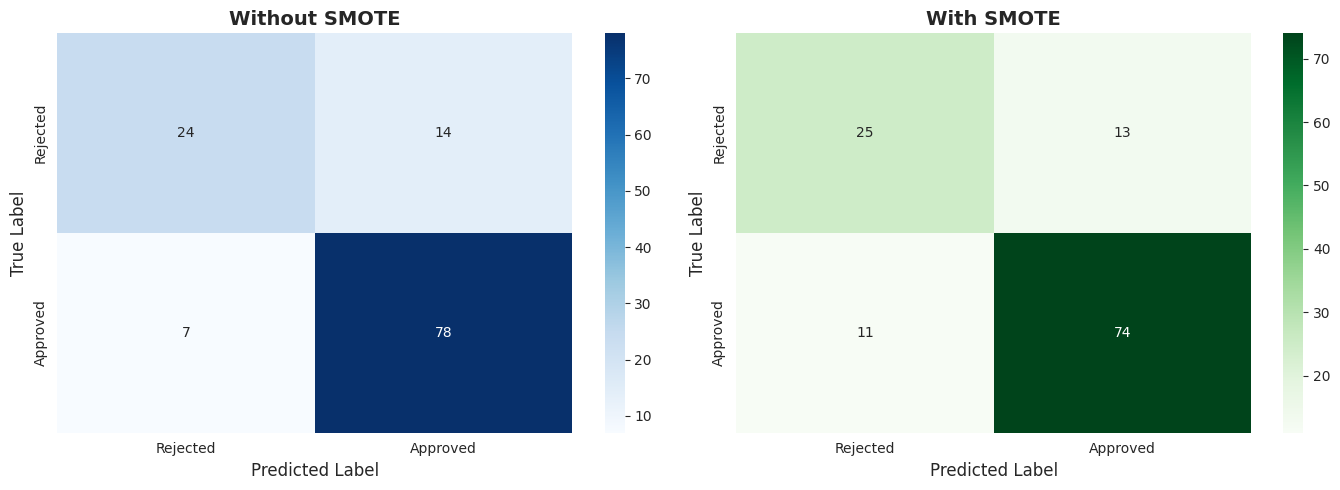

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix - Without SMOTE
cm1 = confusion_matrix(y_test, y_pred_imbalanced)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
axes[0].set_title('Without SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Confusion Matrix - With SMOTE
cm2 = confusion_matrix(y_test, y_pred_balanced)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
axes[1].set_title('With SMOTE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()


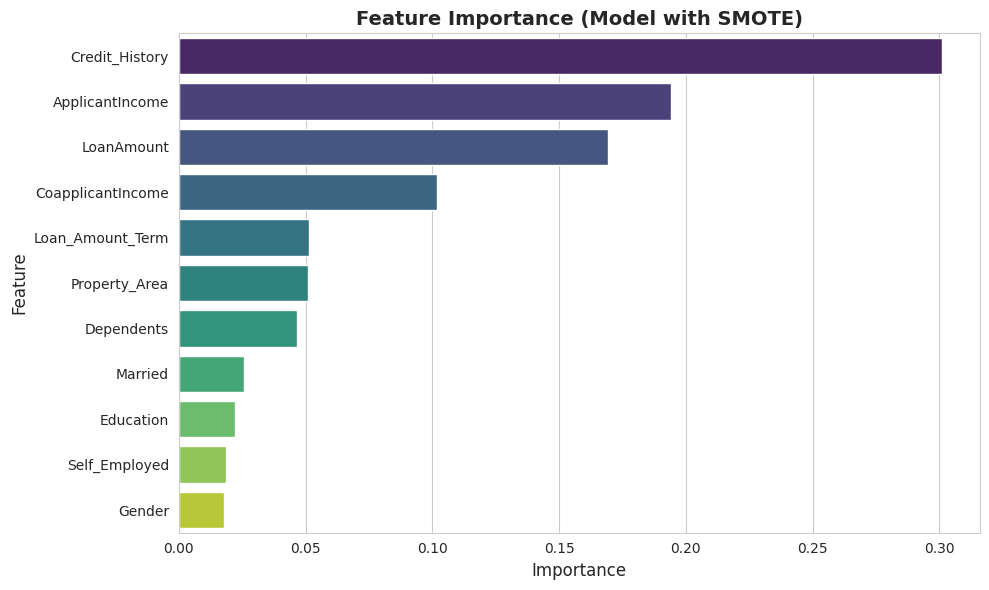


Feature Importance:
              Feature  Importance
9      Credit_History    0.300990
5     ApplicantIncome    0.194230
7          LoanAmount    0.169304
6   CoapplicantIncome    0.101817
8    Loan_Amount_Term    0.051301
10      Property_Area    0.051143
2          Dependents    0.046786
1             Married    0.025866
3           Education    0.022200
4       Self_Employed    0.018604
0              Gender    0.017759


In [25]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_balanced.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance (Model with SMOTE)', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance)
